In [2]:
#pip install keras
#pip install -U scikit-learn
#pip install pillow
#pip install matplotlib
#pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [4]:
"""
Notes for tmrw

u reduced batch size to 16 and u saw some improvements still plateuing
now ur pissed off coz accuracy is not increasing even though u put 0 data augmentation
tmrw I have to look into that"""

'\nNotes for tmrw\n\nu reduced batch size to 16 and u saw some improvements still plateuing\nnow ur pissed off coz accuracy is not increasing even though u put 0 data augmentation\ntmrw I have to look into that'

## Variables Being Used

In [5]:
#variables being used
batch_size=32
#val_split=0.2 #20 percent validation
image_size=512 
image_shape=(image_size,image_size)
#file_directory='/root/DR no aug'
#file_directory='/root/01DR_noDR'
train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training'
validation_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Validation'
alt_train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training_no_weights'

In [6]:
!nvidia-smi

Sun Apr  2 08:12:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 37%   36C    P8    26W / 420W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Datasets

In [7]:

from keras.applications.vgg16 import preprocess_input #for that vgg16
#import tensorflow as tf

#from keras.applications.Xception import preprocess_input

training_datagen = ImageDataGenerator( 
        preprocessing_function=preprocess_input, # use this only when using VGG16
        #rescale=1./255,
        #rotation_range=15,#can change this
        #shear_range=0.1,#can change this
        #zoom_range=0.1, #can change this
        #horizontal_flip=True,
        #fill_mode='constant',# constant,reflect,wrap,
        )

validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255    
        )

#Creating our generators, no need of changing values here
train_generator = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
        )

validation_generator = validation_datagen.flow_from_directory( #Creating our validation generator
        validation_file_directory, 
        target_size=image_shape, 
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
)

Found 561 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


## Displaying Images

In [8]:
# Enable/Disable to see 4 random images
"""fig, axs=plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)
#axs[0].plt.show()"""

"fig, axs=plt.subplots(ncols=4, figsize=(20,20))\nfor i in range(4):\n  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)\n#axs[0].plt.show()"

## Creating weights

In [9]:
import numpy as np ## Calculating the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weighing = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights=dict(zip(np.unique(train_generator.classes), class_weighing))

print(class_weights)

{0: 0.6051779935275081, 1: 0.9739583333333334, 2: 3.1166666666666667}


## Creating Model

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
import keras

In [57]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

base_model.trainable = False
inputs = keras.Input(shape=(image_size, image_size, 3))

#for layer in base_model.layers[:15]:
#   layer.trainable = False
#for layer in base_model.layers[15:]:
#   layer.trainable = True

x = base_model(inputs)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.15)(x)  # Regularize with dropout
x=keras.layers.Dense(100)(x)
x=keras.layers.Dense(50)(x)
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.summary(expand_nested=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_7 (InputLayer)      [(None, 512, 512, 3)]     0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 512, 512, 64)      1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 512, 512, 64)      36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 256, 256, 64)    0         |
|                                                               |
| block2_conv1 (Conv2D)     (None, 256, 256, 128)     73856

### Compile

In [58]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), #SGD or adam
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

### Generating Callbacks

In [59]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/root/DR-detection-using-OCT-A/saved_models/VGG16_{val_accuracy:.2f}_{epoch:02d}.hdf5"

checkpoint= ModelCheckpoint(filepath,monitor='val_accuracy',verbose=0,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='val_accuracy',patience=100,verbose=0) #only change patience

callback_list=[checkpoint,early_stop]#add the callbacks used

### Model.Fit()

In [60]:
%%notify
history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//batch_size,
        verbose=1, 
        epochs=300,  #change this
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//batch_size,
        callbacks=callback_list,
        class_weight=class_weights
)
print("Done bro")

Epoch 1/300


2023-04-02 09:30:44.961464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - ETA: 0s - loss: 6.4829 - accuracy: 0.3819

2023-04-02 09:30:51.963889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 8s 426ms/step - loss: 6.4829 - accuracy: 0.3819 - val_loss: 0.3000 - val_accuracy: 0.5312
Epoch 2/300
17/17 [==============================] - 7s 393ms/step - loss: 5.8732 - accuracy: 0.3951 - val_loss: 0.0056 - val_accuracy: 0.5312
Epoch 3/300
17/17 [==============================] - 7s 396ms/step - loss: 5.4118 - accuracy: 0.4008 - val_loss: 1.0075 - val_accuracy: 0.5312
Epoch 4/300
17/17 [==============================] - 7s 391ms/step - loss: 5.3956 - accuracy: 0.4442 - val_loss: 2.0148 - val_accuracy: 0.5312
Epoch 5/300
17/17 [==============================] - 7s 401ms/step - loss: 6.3221 - accuracy: 0.4449 - val_loss: 3.5258 - val_accuracy: 0.5000
Epoch 6/300
17/17 [==============================] - 7s 392ms/step - loss: 6.8623 - accuracy: 0.4102 - val_loss: 4.0295 - val_accuracy: 0.5312
Epoch 7/300
17/17 [==============================] - 7s 393ms/step - loss: 8.7542 - accuracy: 0.4367 - val_loss: 4.5332 - val_accuracy: 0.5312
Epoch 8/300

<IPython.core.display.Javascript object>

### Curves

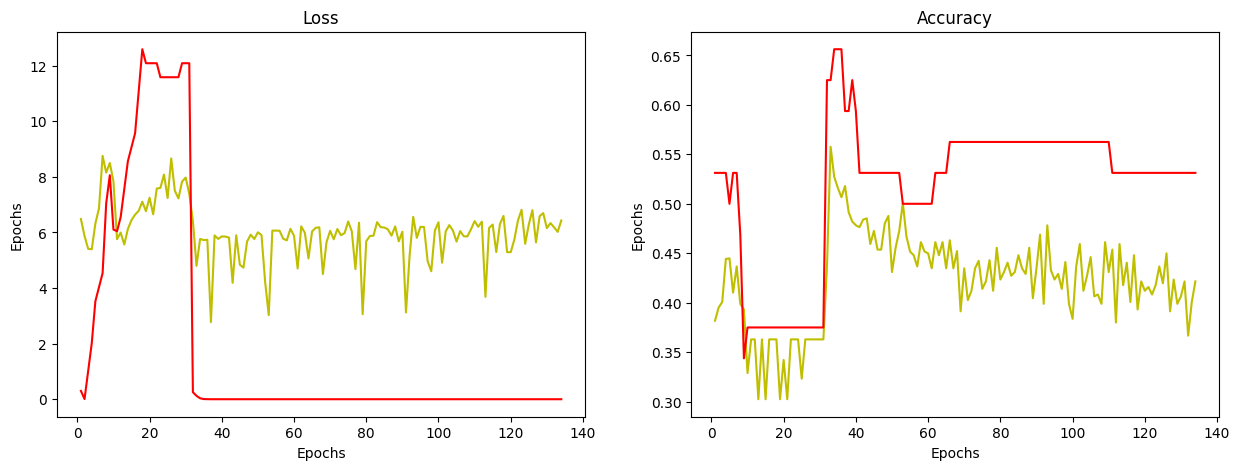

In [61]:
#loss curve
fig, axs=plt.subplots(ncols=2,figsize=(15, 5))#, figsize=(20,20))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set(title='Loss', xlabel='Epochs', ylabel='Epochs');

#accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
axs[1].plot(epochs, acc, 'y', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Epochs');

In [ ]:
"""prediction_classes = np.array([])
true_classes =  np.array([])
i=0
for x, y in validation_generator:
    if i==len(validation_generator.classes):
        break    
    i=i+1
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x,verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
print(classification_report(true_classes, prediction_classes))"""

In [ ]:
#model.save('to_continue.h5')
#continue_model=load_model('to_continue.h5')

## Evaluating Model

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

#model = load_model('/root/44-0.82.hdf5')

In [ ]:
#new_model=load_model(".hdf5")

In [ ]:
data_eval=validation_generator
model_eval=model
results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
print("Loss and accuracy are", results)
Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
#print(train_generator.classes)
y_pred = np.argmax(Y_pred, axis=1)
#print(train_generator.classes)
#print(y_pred)
#print(X)
        
print('Confusion Matrix')
cm=confusion_matrix(data_eval.classes,y_pred)
target_names = ['NoDR', 'mildDR','seriousDR']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')

print(classification_report(data_eval.classes,y_pred, target_names=target_names))